In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from datetime import datetime
from statistics import mean
import math as m

In [55]:
def smoothing(data):
    series = data
    # Tail-rolling average transform
    rolling = series.rolling(window=8)
    rolling_mean = rolling.mean()
    return rolling_mean

In [56]:
def fullDay(data):
        
    dates = list()
    data = data.reset_index(drop=True)
    for i in range(0,len(data.index)):
        dates.append(data['Display Time'][i].date())
    data['Dates'] = dates
    end = data['Dates'].iloc[-1]
    start = data['Dates'].iloc[0]

    indexVals = data[ data['Dates'] == start ].index
    # indexVals
    data.drop(indexVals , inplace=True)

    indexVals = data[ data['Dates'] == end ].index
    # indexVals
    data.drop(indexVals , inplace=True)

    data = data.reset_index(drop=True)

    data.drop(['Dates'], axis=1, inplace=True)

    return data

In [111]:
def mageCalculation(df, std=3):
        """
            This function calculates the mean amplitude glycemic excursions and the excursion frequency of an individual's glucose variability

            Function Parameters:
            df: The default dataset (CSV file) includes data from the CGMAnalysis package, Gluvarpro package, CGMAnalyzer package and the Ohio University with the following format:
            Display Time     object
            GlucoseValue    float64
            subjectId        object
            This data is split based on the subject ID
            type: pandas DataFrame
            
            std: It is the standard deviation for the model. The default value is 1  type: integer
            
            Return:
            The MAGE score and the excursion frequency of the individual
        """
        #extracting glucose values and incdices
#         print(df)
        glucs = df['GlucoseValue'].tolist()
        indices = [1*i for i in range(len(glucs))]
        stdev = std
        
        # detection of local minima and maxima
        x = indices
        gvs = glucs
        # local min & max
        a = np.diff(np.sign(np.diff(gvs))).nonzero()[0] + 1      
        # local min
        valleys = (np.diff(np.sign(np.diff(gvs))) > 0).nonzero()[0] + 1 
        # local max
        peaks = (np.diff(np.sign(np.diff(gvs))) < 0).nonzero()[0] + 1         
        # +1 due to the fact that diff reduces the original index number

        #storing the local minima and maxima to identify and remove turning points
        excursion_points = pd.DataFrame(columns=['Index', 'Timestamp', 'GlucoseValue', 'Type'])
        k=0
        for i in range(len(peaks)):
            excursion_points.loc[k] = [peaks[i]] + [df['Display Time'][k]] + [df['GlucoseValue'][k]] + ["P"]
            k+=1

        for i in range(len(valleys)):
            excursion_points.loc[k] = [valleys[i]] + [df['Display Time'][k]] + [df['GlucoseValue'][k]] + ["V"]
            k+=1

        excursion_points = excursion_points.sort_values(by=['Index'])
        excursion_points = excursion_points.reset_index(drop=True)
        # display(excursion_points)


        # selecting turning points
        turning_points = pd.DataFrame(columns=['Index', 'Timestamp', 'GlucoseValue', 'Type'])
        k=0
        for i in range(stdev,len(excursion_points.Index)-stdev):
            positions = [i-stdev,i,i+stdev]
            for j in range(0,len(positions)-1):
                if(excursion_points.Type[positions[j]] == excursion_points.Type[positions[j+1]]):
                    if(excursion_points.Type[positions[j]]=='P'):
                        if excursion_points.GlucoseValue[positions[j]]>=excursion_points.GlucoseValue[positions[j+1]]:
                            turning_points.loc[k] = excursion_points.loc[positions[j+1]]
                            k+=1
                        else:
                            turning_points.loc[k] = excursion_points.loc[positions[j+1]]
                            k+=1
                    else:
                        if excursion_points.GlucoseValue[positions[j]]<=excursion_points.GlucoseValue[positions[j+1]]:
                            turning_points.loc[k] = excursion_points.loc[positions[j]]
                            k+=1
                        else:
                            turning_points.loc[k] = excursion_points.loc[positions[j+1]]
                            k+=1

        if len(turning_points.index)<10:
            turning_points = excursion_points.copy()
            excursion_count = len(excursion_points.index)
        else:
            excursion_count = len(excursion_points.index)/2



#         turning_points = turning_points.drop_duplicates(subset= "Index", keep= "first")
#         turning_points = turning_points.reset_index(drop=True)
#         excursion_points = excursion_points[excursion_points.Index.isin(turning_points.Index) == False]
#         excursion_points = excursion_points.reset_index(drop=True)
            # display(turning_points)

        # calculating the MAGE score
        mage = turning_points.GlucoseValue.sum()/excursion_count
        

        return round(mage,3), excursion_count, turning_points

In [118]:
data = pd.read_csv("~/Desktop/NCSA_genomics/Python - notebooks/GlucoCheck/Data/consolidatedDataForPackage.csv")
data['Display Time'] = data['Display Time'].apply(lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
data = data[data['subjectId'] == '1636-69-032']
# data = data.reset_index(drop=True)
data = fullDay(data)
data['GlucoseValue'] = smoothing(data['GlucoseValue'])
data = data[data['GlucoseValue'].notna()]
data = data.reset_index(drop=True)



In [119]:
data

,Display Time,GlucoseValue,subjectId
0,2016-01-14 00:38:15,125.750,1636-69-032
1,2016-01-14 00:43:15,127.000,1636-69-032
2,2016-01-14 00:48:15,128.125,1636-69-032
3,2016-01-14 00:53:15,128.875,1636-69-032
4,2016-01-14 00:58:15,129.125,1636-69-032
...,...,...,...
1427,2016-01-18 23:37:52,121.625,1636-69-032
1428,2016-01-18 23:42:52,124.125,1636-69-032
1429,2016-01-18 23:47:52,127.250,1636-69-032
1430,2016-01-18 23:52:52,129.750,1636-69-032


In [126]:
data['Display Time'][12]

Timestamp('2016-01-14 01:38:15')

In [122]:
q,r,e = mageCalculation(data)
e

,Index,Timestamp,GlucoseValue,Type
0,12,2016-01-14 00:48:15,128.125,P
1,71,2016-01-14 12:53:13,128.625,V
2,73,2016-01-14 01:13:15,128.500,P
3,85,2016-01-14 12:58:13,127.375,V
4,154,2016-01-14 01:43:15,126.750,P
...,...,...,...,...
86,1362,2016-01-14 23:23:11,104.000,V
87,1363,2016-01-14 11:48:13,133.875,P
88,1365,2016-01-14 23:33:11,103.375,V
89,1366,2016-01-14 11:53:13,134.875,P


Text(0, 0.5, 'Glucose Values')

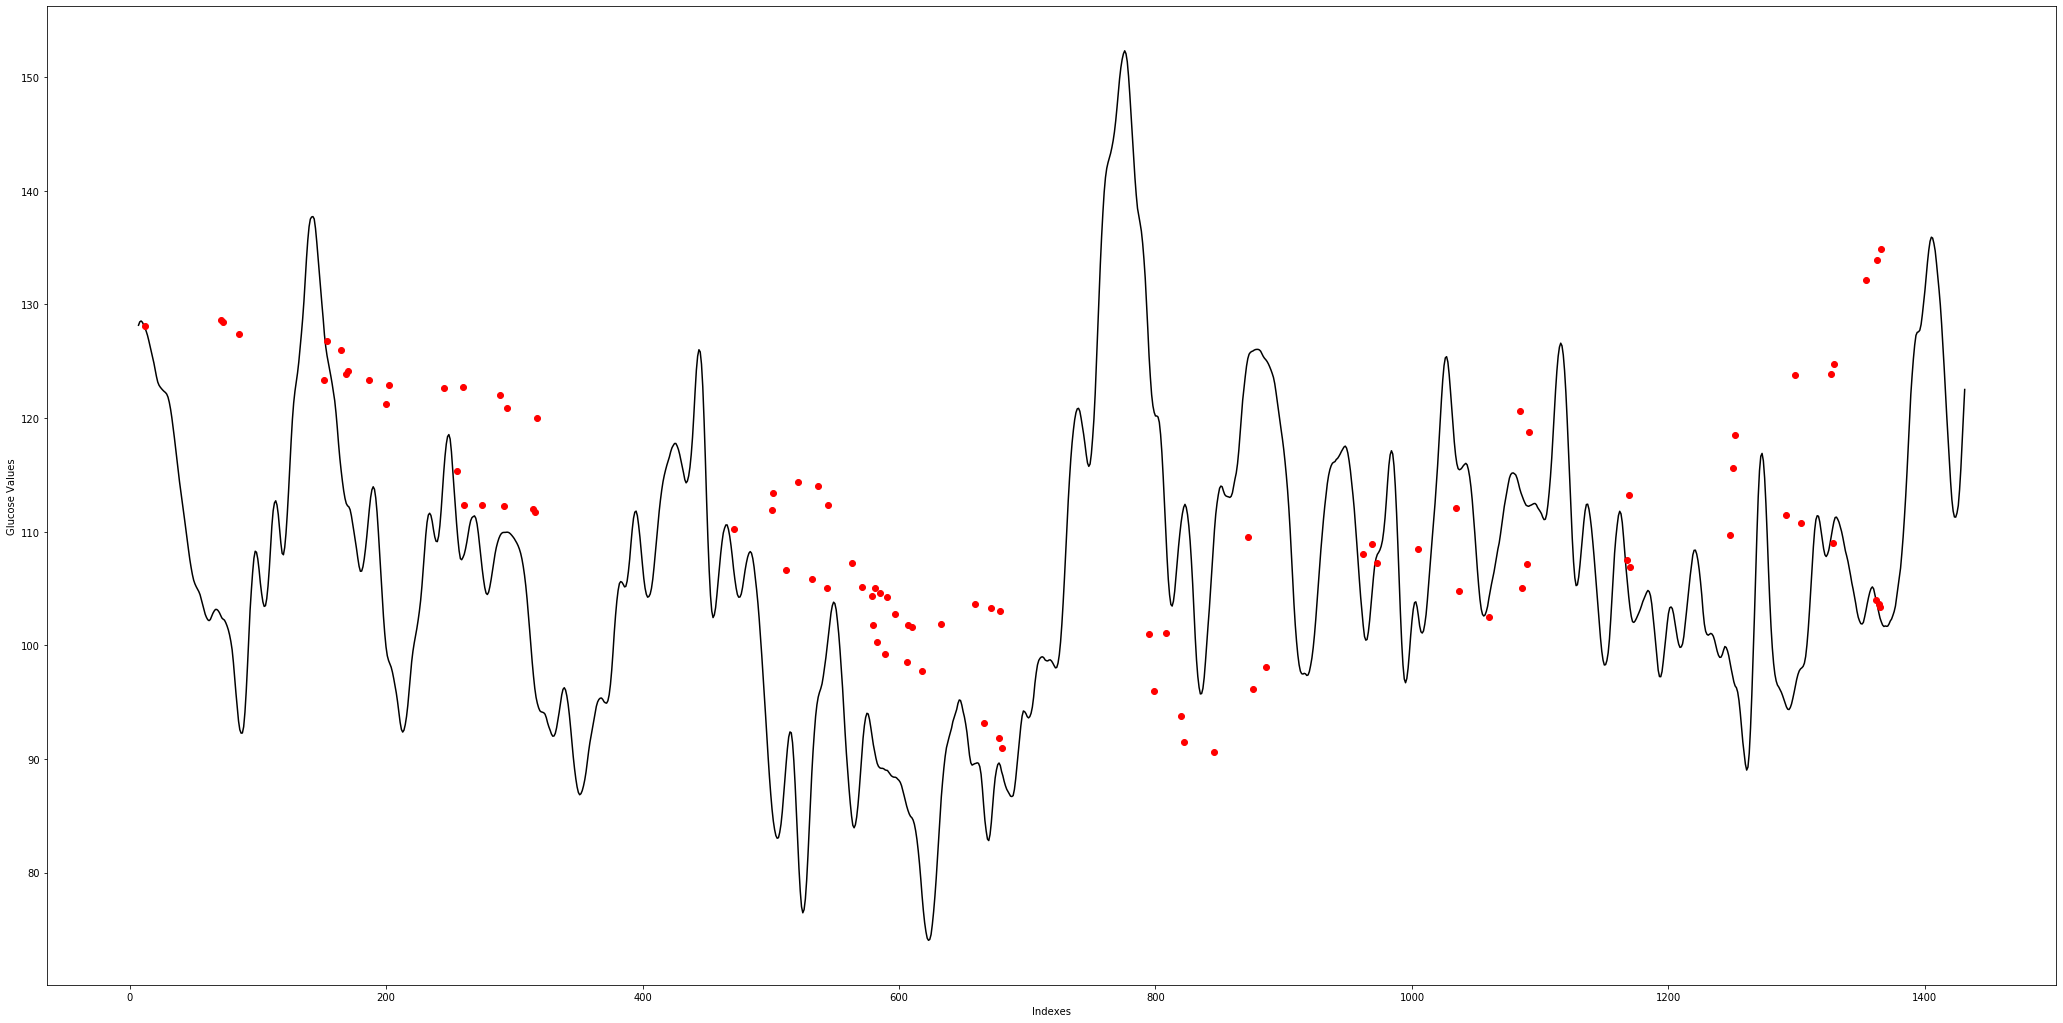

In [115]:
x = data.index
gvs = smoothing(data['GlucoseValue'])
exc = e['GlucoseValue']
x2 = e['Index']

fig = plt.figure(figsize=(36, 18))
plt.plot(x, gvs, color='black')
plt.plot(x2, exc, "o", color='red')

plt.xlabel('Indexes')
plt.ylabel('Glucose Values')

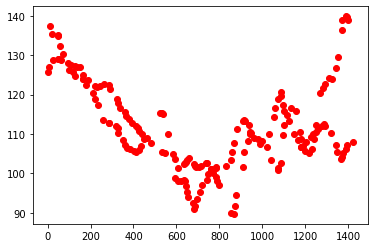

In [109]:
plt.plot(x2, exc, "o", color='red')